In [1]:
import os

In [24]:
from data.dataset import Dataset
from data.feature import Featurizer
from data.dataloader import DataLoader
from methods.ridge_method import RidgeMethod
from methods.bayesian_method import BayesianRidgeMethod
from methods.decision_tree_method import DecisionTreeMethod
from methods.elasticnet_method import ElasticNetMethod
from methods.mlp_method import MlpMethod
from methods.lasso_method import LassoMethod
from methods.random_forest_method import RandomForestMethod
from methods.knn_method import KnnMethod
from methods.lasso_lars_method import LassoLarsMethod
from methods.pca_method import PCAAnalysis

import numpy as np
from visualize import visualize_energy

In [121]:
import pandas as pd

In [132]:
from methods.preprocessing.pca import PCAMethod
from methods.preprocessing.shift import ShiftingMethod
from methods.preprocessing.identity import IdentityMethod

In [123]:
def rmse(y_true, y_pred, y_train):
    return np.sqrt(np.mean((y_true - y_pred) ** 2)) / np.std(y_train)

In [74]:
methods = [RidgeMethod, BayesianRidgeMethod, DecisionTreeMethod, ElasticNetMethod, LassoMethod, RandomForestMethod, KnnMethod, LassoLarsMethod]

In [3]:
featurizer = Featurizer()
#trimer_dataset = Dataset.from_file('xe3_50.xyz', 3, featurizer)
#energy_base = trimer_dataset[-1][1][0]
dimer_dataset = Dataset.from_file('dataset/xe2_50.xyz', 2, featurizer)
trimer_dataset = Dataset.from_file('dataset/xe3_50.xyz', 3, featurizer)
rand_trimer_dataset = Dataset.from_file('dataset/xe3_dataset_dft.xyz', 3, featurizer)

In [107]:
n_dimer_train = 40
n_trimer_train = 40
n_rand_trimer_train = 5000

dimer_train, dimer_val = dimer_dataset.split(
    [list(range(n_dimer_train)),
     list(range(n_dimer_train, len(dimer_dataset)))])
trimer_train, trimer_val = trimer_dataset.split(
    [list(range(n_trimer_train)),
     list(range(n_trimer_train, len(dimer_dataset)))])
rand_trimer_train, rand_trimer_val = rand_trimer_dataset.split(
    [list(range(n_rand_trimer_train)), 
     list(range(n_rand_trimer_train, len(rand_trimer_dataset)))])
train = DataLoader([dimer_train, trimer_train, rand_trimer_train])
val = DataLoader([dimer_val, trimer_val, rand_trimer_val])
dimer_val = DataLoader([dimer_val])
trimer_val = DataLoader([trimer_val])
rand_trimer_val = DataLoader([rand_trimer_val])

In [150]:
pca = PCAMethod(20)
shift = ShiftingMethod(-205862)

In [151]:
train = DataLoader([dimer_train, trimer_train, rand_trimer_train])
val = DataLoader([dimer_val, trimer_val, rand_trimer_val])
train.X = pca.fit_preprocess(train.X)
train.y = shift.fit_preprocess(train.y)

/home/qjxu/miniconda3/envs/pj2/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/qjxu/miniconda3/envs/pj2/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/qjxu/miniconda3/envs/pj2/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/qjxu/miniconda3/envs/pj2/lib/python3.9/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y 

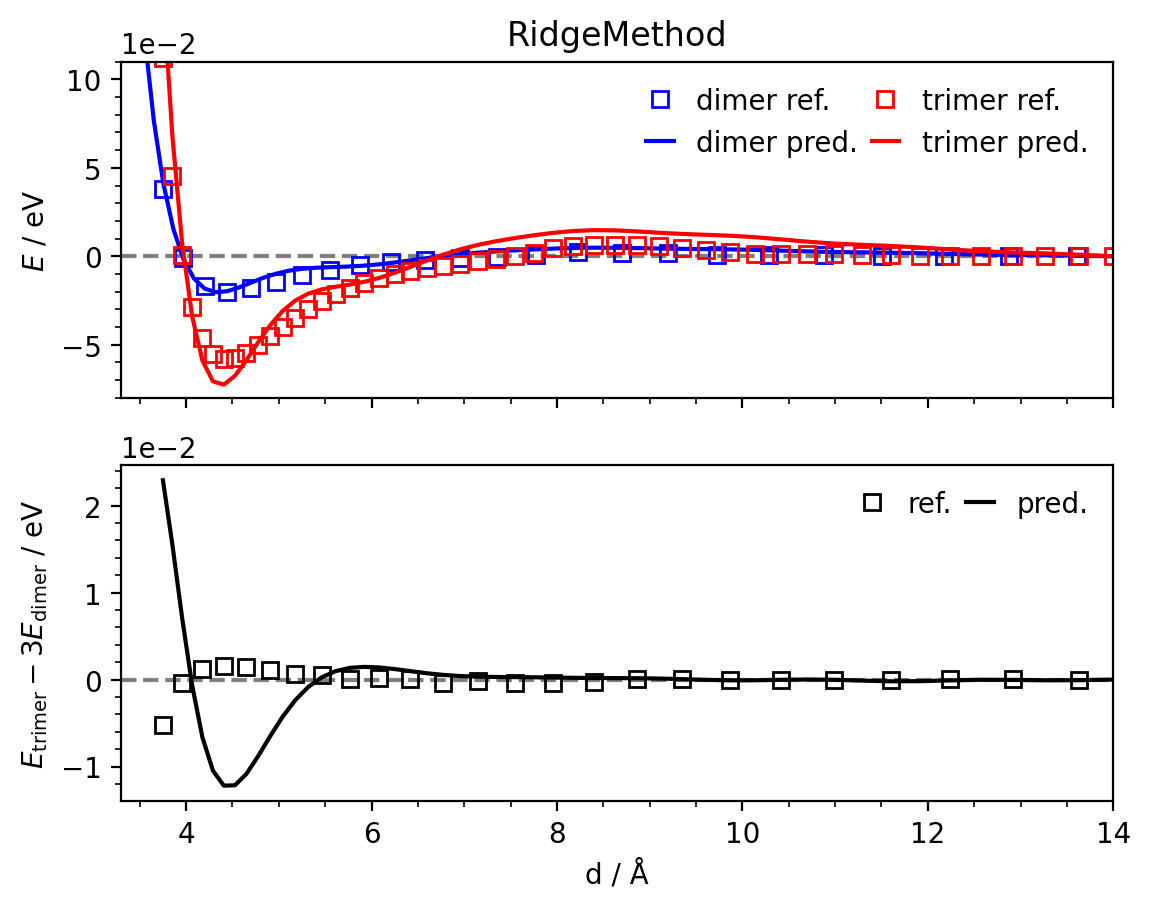

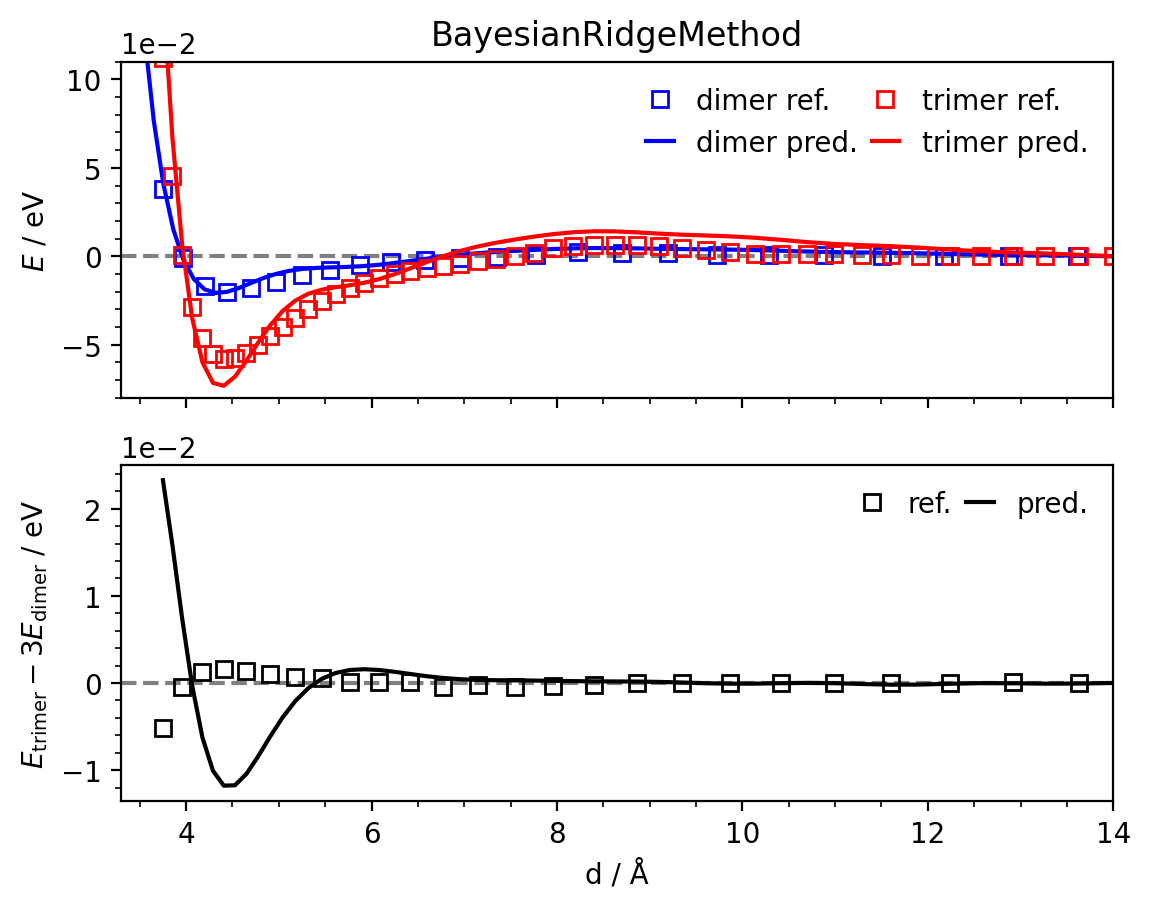

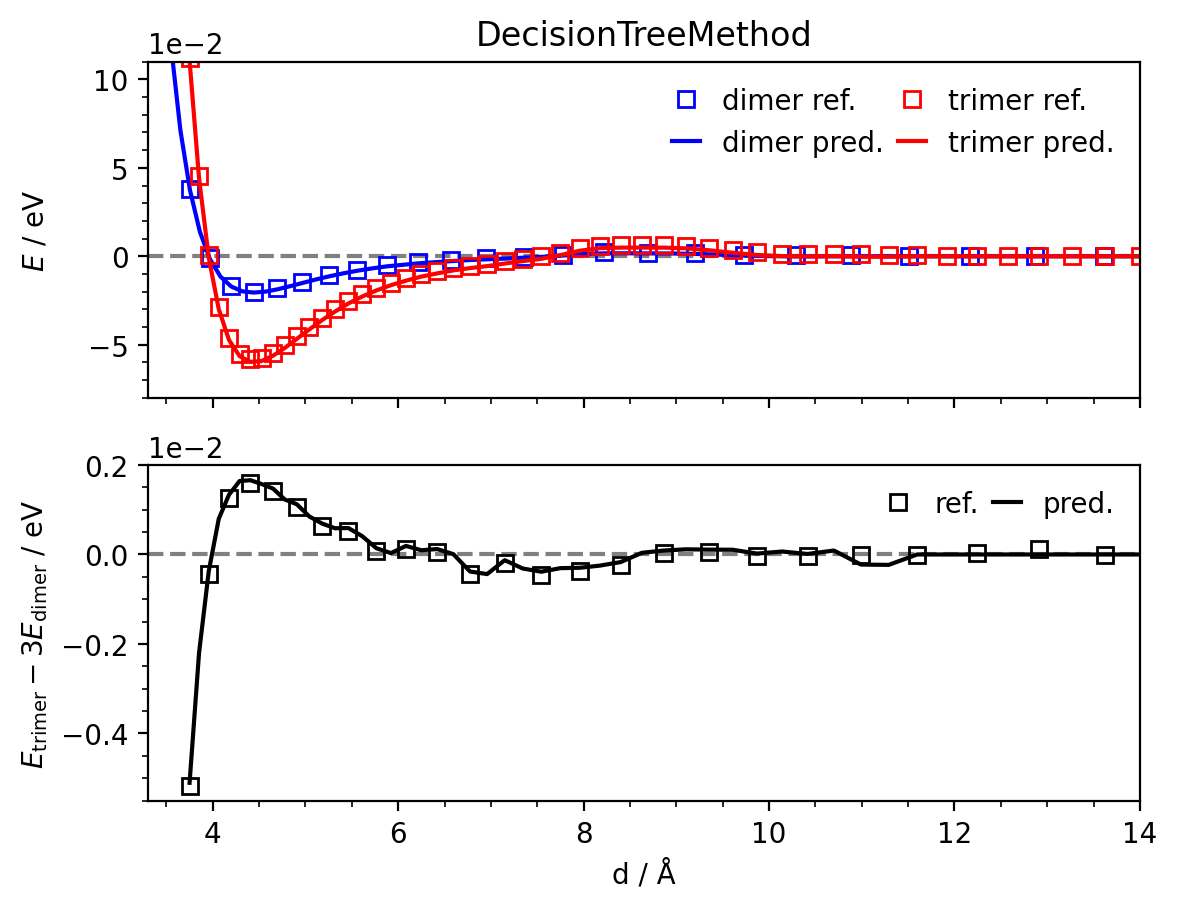

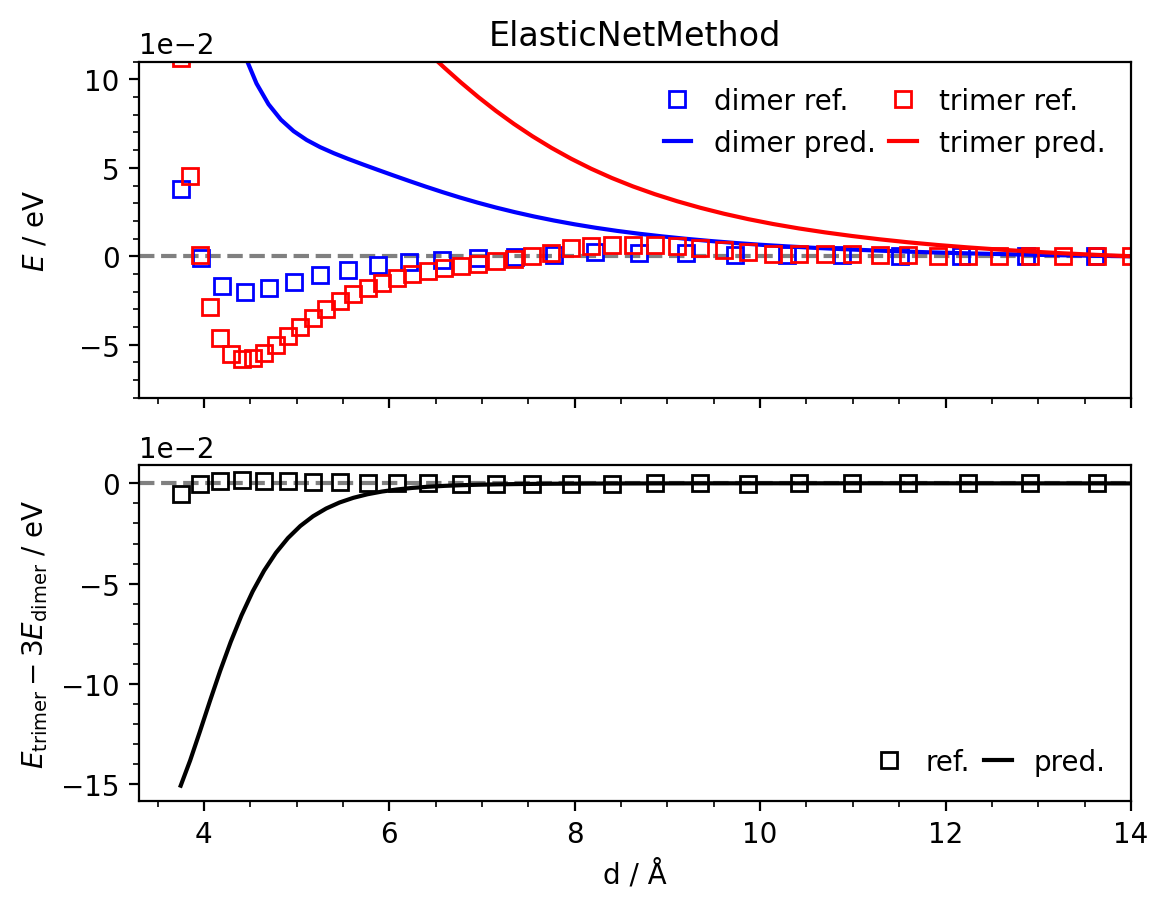

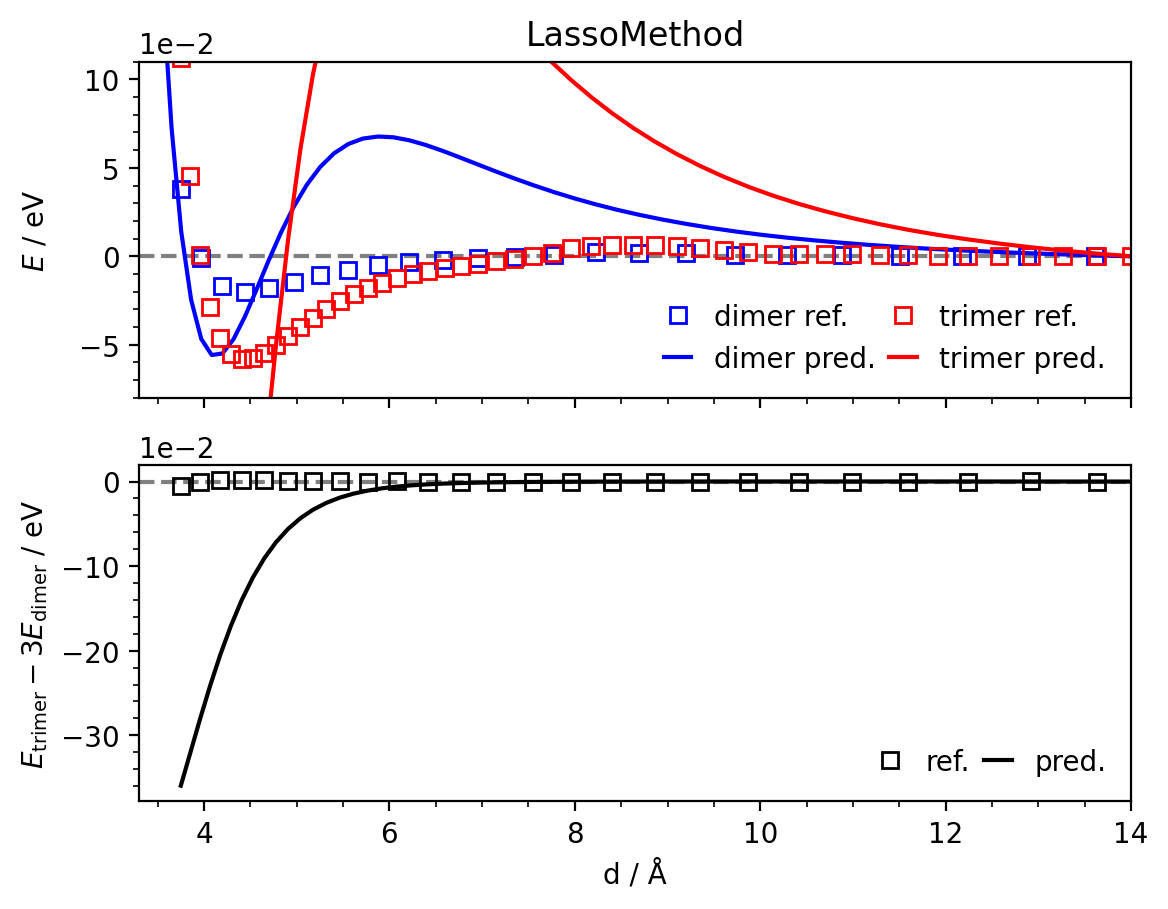

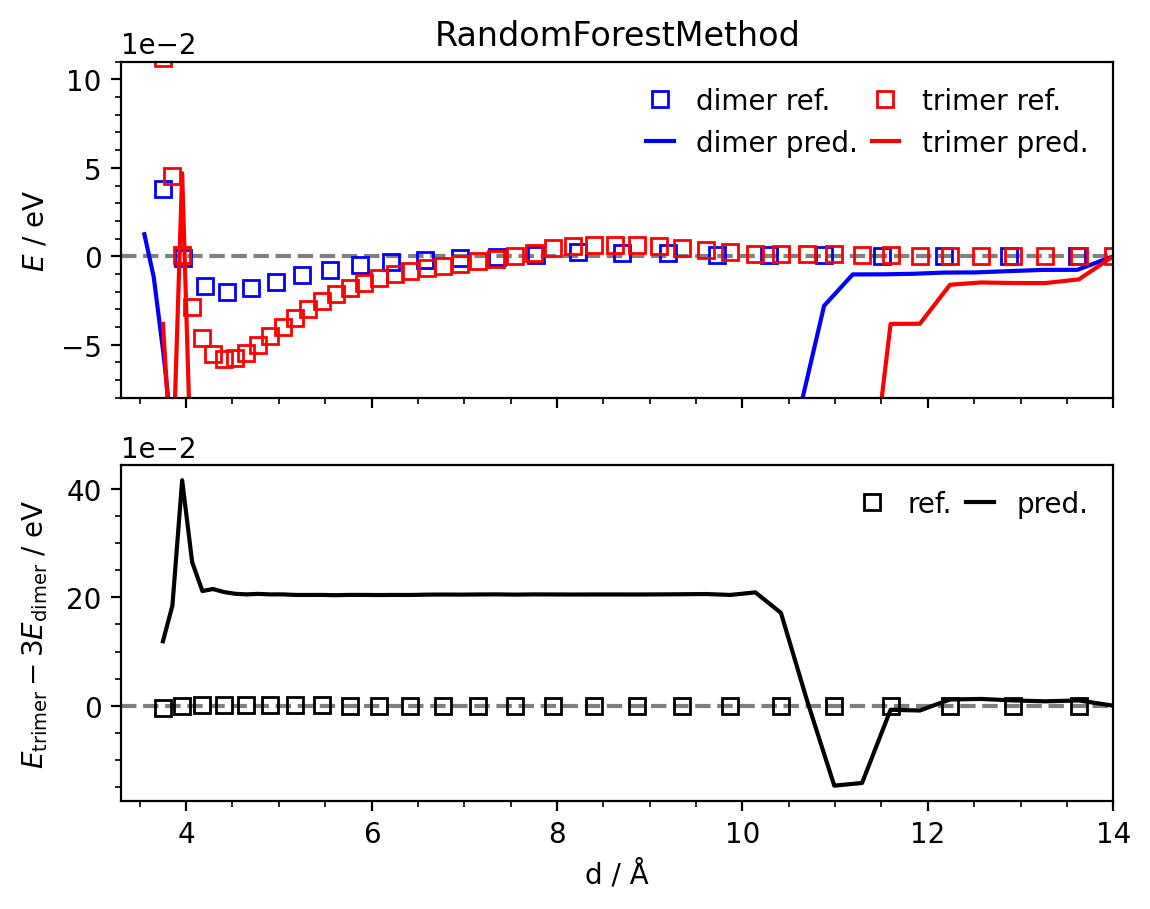

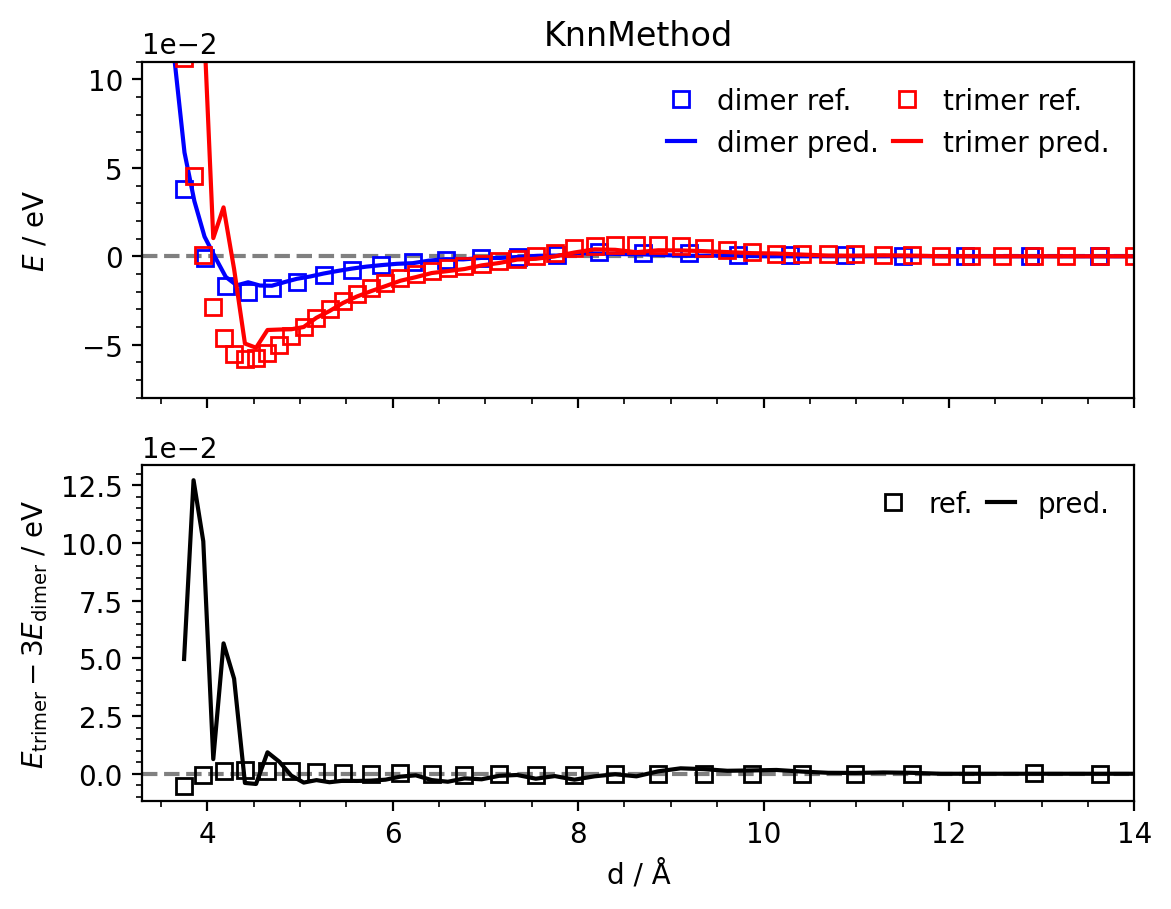

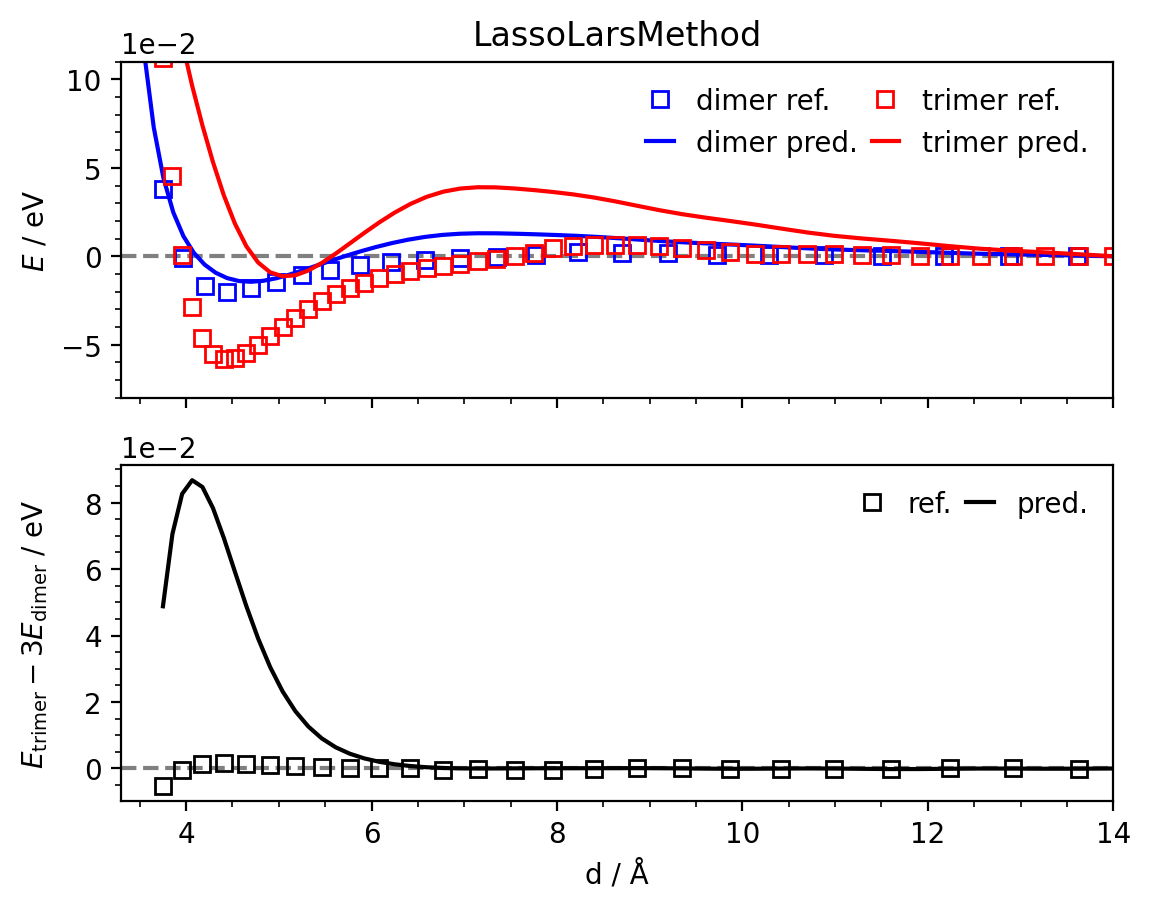

In [152]:
data = pd.DataFrame(columns=['%RMSE$_{dimer}$', '%RMSE$_{trimer}$', '%RMSE$_{rand_trimer}$'])

for method in methods:
    m = method(train)
    m.train()
    dimer_energy = shift.backward(m.predict(pca.preprocess(dimer_dataset.X))) * 2
    trimer_energy = shift.backward(m.predict(pca.preprocess(trimer_dataset.X))) * 3
    fig, ax = visualize_energy(dimer_dataset, dimer_energy - dimer_energy[-1], trimer_dataset, trimer_energy - trimer_energy[-1])
    val_dimer_energy = shift.backward(m.predict(pca.preprocess(dimer_val.X))) * 2
    val_trimer_energy = shift.backward(m.predict(pca.preprocess(trimer_val.X))) * 3
    val_rand_trimer_energy = shift.backward(m.predict(pca.preprocess(rand_trimer_val.X))) * 3
    data.loc[method.__name__] = [
        rmse(val_dimer_energy, dimer_val.y * 2, train.y[:n_dimer_train]), 
        rmse(val_trimer_energy, trimer_val.y * 3, train.y[50:50+n_trimer_train]), 
        rmse(val_rand_trimer_energy, rand_trimer_val.y * 3, train.y[100:100+n_rand_trimer_train])]
    
    ax[0].set_title(method.__name__)

In [153]:
data

,%RMSE$_{dimer}$,%RMSE$_{trimer}$,%RMSE$_{rand_trimer}$
RidgeMethod,0.521533,0.026285,0.017474
BayesianRidgeMethod,0.493338,0.025690,4.301566
DecisionTreeMethod,0.034692,0.008805,4.307763
ElasticNetMethod,9.266712,1.212228,4.020386
LassoMethod,5.154016,0.603862,4.255602
RandomForestMethod,10.119775,1.180617,4.295478
KnnMethod,0.056060,0.008032,0.291437
LassoLarsMethod,1.327965,0.118183,4.298897
